In [1]:
import numpy as np
!pip install -U jax[cuda112] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -U jaxlib[cuda112] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install optax
!pip install dm-haiku
!pip install tensorflow-probability
!pip install tensorflow-datasets
!pip install imbalanced-learn
!pip install -U git+https://github.com/Habush/Sklearn-genetic-opt.git
!pip install git+https://github.com/blackjax-devs/blackjax.git

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jax: filename=jax-0.3.21-py3-none-any.whl size=1263550 sha256=4a7a88ed3b11f3c64f62049489fa60c53dd6d9cf335d1125dacbeb516932a6cb
  Stored in directory: /root/.cache/pip/wheels/cd/fe/13/b51a21b340580b56f5378c5e68d14d19e74e956d575397c41f
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 MB 10.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.8+cuda11.cudnn82
    Uninstalling jaxlib-0.3.8+cuda11.cudnn82:
      Successfully uninstalled jaxlib-0.3.8+cuda11.cudnn82
  

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
SERVER = 0

In [2]:
if not SERVER:
    %cd /home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
tfd = tfp.distributions
from nn_util import *
from nn_models import *
from gibbs_sampler import *
from sgmcmc import *

plt.style.use('ggplot')
%load_ext autoreload

/home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn


/home/xabush/miniconda3/lib/python3.9/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [3]:
if SERVER:
    data_dir = "."
else:
    data_dir = "/home/xabush/code/snet/moses-incons-pen-xp/data"

In [4]:
tamox_df = pd.read_csv(f"{data_dir}/tamoxBinaryEntrez.csv")
tamox_df.head()

,posOutcome,4111,4110,10661,131,4438,330,1109,2637,2642,...,7634,55769,7637,7644,741,54993,79364,7791,23140,26009
0,0,0,0,0,1,0,1,1,1,1,...,0,0,0,1,1,0,0,1,0,0
1,1,1,0,0,0,0,0,1,0,1,...,0,0,0,1,1,0,0,1,0,1
2,0,0,0,0,1,0,0,1,1,1,...,0,0,0,1,1,0,0,1,0,0
3,0,0,0,0,0,0,0,1,1,1,...,0,0,0,1,0,0,0,1,0,0
4,1,0,0,0,0,0,1,1,1,1,...,0,0,0,1,1,0,0,1,0,0


In [5]:
regnet_df = pd.read_table(f"{data_dir}/human.source", sep="\t", header=None, names= ["REGULATOR SYMBOL", "REGULATOR ID", "TARGET SYMBOL", "TARGET ID"])
print(f"Total interactions: {regnet_df.shape[0]}")
regnet_df.head()

Total interactions: 372774


/tmp/ipykernel_2150/3470585798.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  regnet_df = pd.read_table(f"{data_dir}/human.source", sep="\t", header=None, names= ["REGULATOR SYMBOL", "REGULATOR ID", "TARGET SYMBOL", "TARGET ID"])


,REGULATOR SYMBOL,REGULATOR ID,TARGET SYMBOL,TARGET ID
0,USF1,7391,S100A6,6277
1,USF1,7391,DUSP1,1843
2,USF1,7391,C4A,720
3,USF1,7391,ABCA1,19
4,TP53,7157,TP73,7161


In [6]:
net_intr = pd.Series(regnet_df["REGULATOR ID"].values, index=regnet_df["TARGET ID"])
net_intr_rev = pd.Series(regnet_df["TARGET ID"].values, index=regnet_df["REGULATOR ID"])
X_df, y_df = tamox_df[tamox_df.columns.difference(["posOutcome"])], tamox_df["posOutcome"]

In [7]:
seed = 1234
rng_key = jax.random.PRNGKey(seed)

In [8]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, random_state=seed, shuffle=True, stratify=y_df, test_size=0.3)

### Cosmic Genes

In [7]:
cosmic_genes_df = pd.read_csv(f"{data_dir}/cosmic_genes.csv")
cosmic_genes_df = cosmic_genes_df[~cosmic_genes_df["Entrez GeneId"].isnull()]
cosmic_genes_ids = cosmic_genes_df["Entrez GeneId"].astype(int)
cosmic_genes_ids = cosmic_genes_ids.to_list()
len(cosmic_genes_ids)

729

In [8]:
cols = X_df.columns.to_list()
cols = [int(c) for c in cols]
cosmic_intr = list(set(set(cosmic_genes_ids) & set(cols)))
cosmic_intr = [str(c) for c in cosmic_intr]
len(cosmic_intr)

497

In [9]:
J = build_network(X_df.loc[:, cosmic_intr], net_intr, net_intr_rev)
p = J.shape[0]
print(np.count_nonzero(J) // 2)

242


In [10]:
X_cosmic = X_df.loc[:,cosmic_intr]

In [11]:
X_train_sig, X_test_sig = X_train_df.loc[:,cosmic_intr], X_test_df.loc[:, cosmic_intr]

NameError: name 'X_train_df' is not defined

In [14]:
X_train, X_test, y_train, y_test = X_train_sig.to_numpy(), X_test_sig.to_numpy(), \
                                   y_train_df.to_numpy(), y_test_df.to_numpy()

# X_train, X_test, y_train, y_test = jax.device_put(X_train), jax.device_put(X_test), \
#                                    jax.device_put(y_train), jax.device_put(y_test)

In [15]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

### Logistic Regression and SVM

In [32]:
from sklearn.linear_model import LogisticRegression
log_param_grid = {"C": np.logspace(-2, 1, 10)}
log_grid_cv = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=log_param_grid, verbose=3,
                           scoring="roc_auc", cv=cv).fit(X_train, y_train)
print(log_grid_cv.best_params_)
clf = LogisticRegression(max_iter=10000,  **log_grid_cv.best_params_)
log_cv_score_1 = np.mean(cross_val_score(clf, X_train, y_train, scoring="roc_auc", cv=cv))
clf.fit(X_train, y_train)
log_test_score_1 = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(f"cv score: {log_cv_score_1}, test_score: {log_test_score_1}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ............................C=0.01;, score=0.594 total time=   0.1s
[CV 2/5] END ............................C=0.01;, score=0.748 total time=   0.2s
[CV 3/5] END ............................C=0.01;, score=0.638 total time=   0.3s
[CV 4/5] END ............................C=0.01;, score=0.690 total time=   0.1s
[CV 5/5] END ............................C=0.01;, score=0.747 total time=   0.1s
[CV 1/5] END ............C=0.021544346900318832;, score=0.612 total time=   0.0s
[CV 2/5] END ............C=0.021544346900318832;, score=0.747 total time=   0.0s
[CV 3/5] END ............C=0.021544346900318832;, score=0.652 total time=   0.2s
[CV 4/5] END ............C=0.021544346900318832;, score=0.687 total time=   0.0s
[CV 5/5] END ............C=0.021544346900318832;, score=0.735 total time=   0.1s
[CV 1/5] END ............C=0.046415888336127774;, score=0.624 total time=   0.0s
[CV 2/5] END ............C=0.046415888336127774;

In [20]:
from sklearn.svm import SVC
svc_param_grid = {"C": np.logspace(-2, 1, 10), "kernel": ["rbf", "linear", "poly"], "degree": [2, 3]}
svc_grid_cv = GridSearchCV(estimator=SVC(probability=True), param_grid=svc_param_grid, verbose=3,
                           scoring="roc_auc", cv=cv).fit(X_train, y_train)
print(svc_grid_cv.best_params_)
clf = SVC(probability=True,  **svc_grid_cv.best_params_)
svc_cv_score = np.mean(cross_val_score(clf, X_train, y_train, scoring="roc_auc", cv=cv))
clf.fit(X_train, y_train)
svc_test_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(f"cv score: {svc_cv_score}, test_score: {svc_test_score}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END ......C=0.01, degree=2, kernel=rbf;, score=0.533 total time=   0.5s
[CV 2/5] END ......C=0.01, degree=2, kernel=rbf;, score=0.788 total time=   0.2s
[CV 3/5] END ......C=0.01, degree=2, kernel=rbf;, score=0.657 total time=   0.2s
[CV 4/5] END ......C=0.01, degree=2, kernel=rbf;, score=0.693 total time=   0.1s
[CV 5/5] END ......C=0.01, degree=2, kernel=rbf;, score=0.735 total time=   0.5s
[CV 1/5] END ...C=0.01, degree=2, kernel=linear;, score=0.606 total time=   0.1s
[CV 2/5] END ...C=0.01, degree=2, kernel=linear;, score=0.735 total time=   0.1s
[CV 3/5] END ...C=0.01, degree=2, kernel=linear;, score=0.676 total time=   0.1s
[CV 4/5] END ...C=0.01, degree=2, kernel=linear;, score=0.701 total time=   0.1s
[CV 5/5] END ...C=0.01, degree=2, kernel=linear;, score=0.705 total time=   0.1s
[CV 1/5] END .....C=0.01, degree=2, kernel=poly;, score=0.523 total time=   0.1s
[CV 2/5] END .....C=0.01, degree=2, kernel=poly

### BNN

In [21]:
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn_genetic import GASearchCV
gamma_params = Continuous(0, 10., distribution="uniform")
sigmas = Continuous(0., 10, distribution="uniform")
temps = Continuous(0., 10, distribution="uniform")
param_grid = {"eta": gamma_params, "mu": gamma_params, "temp": temps,
              "sigma": sigmas}

In [22]:
%autoreload
from sgmcmc import MixedSGMCMC
from sklearn_genetic.callbacks import ProgressBar
from sklearn_genetic.callbacks import DeltaThreshold, TimerStopping
delta_callback = DeltaThreshold(threshold=0.001, generations=2, metric='fitness')
timer_callback = TimerStopping(total_seconds=3600)
progres_callback = ProgressBar()
mixed_sgmcmc = MixedSGMCMC(seed=seed, n_samples=2000, n_chains=1, disc_lr=1e-1, layer_dims=[350],
                           lr_schedule="cyclical", batch_size=20, cycle_len=10)
evolved_grid_cv = GASearchCV(estimator=mixed_sgmcmc, cv=cv,
                             param_grid=param_grid, verbose=True, population_size=10, generations=3).fit(X_train, y_train, callbacks=[progres_callback, delta_callback, timer_callback],  J=J, activation_fns=["tanh"])

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/jax/_src/numpy/lax_numpy.py:3326: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.607591	0.0726662  	0.677481   	0.458901   
1  	20    	0.663184	0.0138455  	0.677481   	0.637073   
2  	20    	0.673766	0.00554944 	0.681845   	0.6635     
3  	20    	0.677093	0.00604429 	0.683225   	0.6635     


In [23]:
evolved_grid_cv.best_params_

{'eta': 5.481751028713134,
 'mu': 6.072047578454063,
 'temp': 8.402038527687969,
 'sigma': 0.11192487201077794}

In [16]:
sgmcmc_best_params = {'eta': 5.481751028713134,
                      'mu': 6.072047578454063,
                      'temp': 8.402038527687969,
                      'sigma': 0.11192487201077794}

In [24]:
mixed_sgmcmc = MixedSGMCMC(seed=seed, lr_schedule="cyclical", n_samples=2000, n_chains=1, disc_lr=1e-1, contin_lr=1e-5,
                           batch_size=20, layer_dims=[350], cycle_len=10, **sgmcmc_best_params)

cv_score = cross_val_score(mixed_sgmcmc, X_train, y_train, cv=cv, fit_params={"J": J, "activation_fns": ["tanh"]})
print(np.mean(cv_score))
mixed_sgmcmc.fit(X_train, y_train, J=J, activation_fns=["tanh"])
mixed_sgmcmc.score(X_test, y_test)

/usr/local/lib/python3.9/dist-packages/jax/_src/numpy/lax_numpy.py:3326: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


0.6816472163605031


0.646644547777659

In [17]:
mixed_sgmcmc = MixedSGMCMC(seed=seed, lr_schedule="cyclical", n_samples=2000, n_chains=1, disc_lr=1e-1, contin_lr=1e-5,
                           batch_size=20, layer_dims=[350], cycle_len=10, **sgmcmc_best_params)

bnn_cv_score = np.mean(cross_val_score(mixed_sgmcmc, X_train, y_train, cv=cv, fit_params={"J": J, "activation_fns": ["tanh"]}))
mixed_sgmcmc.fit(X_train, y_train, J=J, activation_fns=["tanh"])
bnn_test_score = mixed_sgmcmc.score(X_test, y_test)
print(f"cv score: {bnn_cv_score}, test score: {bnn_test_score}")

/usr/local/lib/python3.9/dist-packages/jax/_src/numpy/lax_numpy.py:3327: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


cv score: 0.6816472163605031, test score: 0.646644547777659


Text(0, 0.5, 'num features')

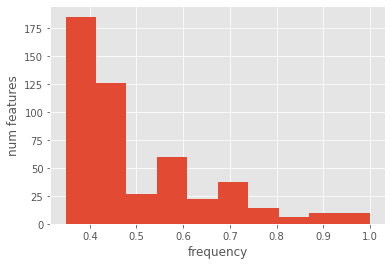

In [18]:
gamma_means = jnp.mean(mixed_sgmcmc.states_.discrete_position, axis=0)
plt.hist(gamma_means)
plt.xlabel("frequency")
plt.ylabel("num features")

In [57]:
gamma_idx = jnp.argwhere(gamma_means > 0.7).ravel()
print(len(gamma_idx))
gamma_idx

68


DeviceArray([ 12,  15,  17,  21,  30,  31,  41,  46,  50,  53,  54,  55,
              56,  57,  74,  86, 100, 101, 106, 109, 131, 134, 136, 138,
             167, 179, 189, 191, 193, 203, 208, 211, 215, 226, 229, 235,
             239, 250, 255, 272, 282, 283, 287, 291, 292, 297, 301, 303,
             304, 307, 313, 318, 329, 330, 356, 374, 393, 394, 403, 432,
             435, 447, 464, 484, 487, 490, 492, 493], dtype=int32)

In [58]:
# sel_entrz_id = X_train_sig.iloc[:,gamma_idx].columns.to_list()
# with open(f"{data_dir}/exp_data_4/cancer/sel_entrz_id.txt", "w") as fp:
#     for i in sel_entrz_id:
#         fp.write(f"{i}\n")

In [59]:
sel_entrz_id = []

with open(f"{data_dir}/exp_data_4/cancer/sel_entrz_id.txt", "r") as fp:
    for line in fp.readlines():
        sel_entrz_id.append(line.strip())

len(sel_entrz_id)

68


### MOSES Run

In [60]:
X_train_sel, X_test_sel = X_train_df.loc[:, sel_entrz_id], X_test_df.loc[:, sel_entrz_id]
X_train_sel.shape

(449, 68)

In [72]:
%autoreload
from moses_estimator import *

moses_grid_params = {"complexity_ratio": np.logspace(0, 3, 5), "complexity_temp": np.logspace(1, 3, 5),
                     "diversity_pressure": [0.0, 0.3, 0.6, 0.9], "hc_fraction_nn": [0.01, 0.1],
                     }

moses_est = MosesEstimator(seed=1234, num_models=100, num_evals=1000, prob="it")


moses_grid_cv = GridSearchCV(estimator=moses_est, param_grid=moses_grid_params, verbose=3,
                             cv=cv).fit(X_train_sel, y_train_df, output_label="posOutcome")

print(moses_grid_cv.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END complexity_ratio=1.0, complexity_temp=10.0, diversity_pressure=0.0, hc_fraction_nn=0.01;, score=0.566 total time=   3.9s
[CV 2/5] END complexity_ratio=1.0, complexity_temp=10.0, diversity_pressure=0.0, hc_fraction_nn=0.01;, score=0.590 total time=   3.8s
[CV 3/5] END complexity_ratio=1.0, complexity_temp=10.0, diversity_pressure=0.0, hc_fraction_nn=0.01;, score=0.570 total time=   4.2s
[CV 4/5] END complexity_ratio=1.0, complexity_temp=10.0, diversity_pressure=0.0, hc_fraction_nn=0.01;, score=0.606 total time=   5.6s
[CV 5/5] END complexity_ratio=1.0, complexity_temp=10.0, diversity_pressure=0.0, hc_fraction_nn=0.01;, score=0.586 total time=   5.1s
[CV 1/5] END complexity_ratio=1.0, complexity_temp=10.0, diversity_pressure=0.0, hc_fraction_nn=0.1;, score=0.627 total time=   1.5s
[CV 2/5] END complexity_ratio=1.0, complexity_temp=10.0, diversity_pressure=0.0, hc_fraction_nn=0.1;, score=0.600 total time=   1.5s


In [72]:
%autoreload
from moses_estimator import *
moses_best_params = {'complexity_ratio': 31.622776601683793,
                     'complexity_temp': 1000.0,
                     'diversity_pressure': 0.3, 'hc_fraction_nn': 0.1}
moses_est = MosesEstimator(seed=1234, num_models=100, num_evals=1000,
                           prob="it", **moses_best_params)
cv_score = cross_val_score(moses_est, X_train_sel, y_train_df, cv=cv, fit_params={"output_label": "posOutcome"})
print(np.mean(cv_score))
moses_est.fit(X_train_sel, y_train_df, output_label="posOutcome")
moses_est.score(X_test_sel, y_test_df)

0.6374533799533799


0.6177161005247169

In [73]:
# import pickle
# with open(f"{data_dir}/exp_data_4/moses_best_params_s_1234_cosmic.pickle", "wb") as fp:
#     pickle.dump(moses_grid_cv.best_params_, fp, protocol=pickle.HIGHEST_PROTOCOL)

train_eval_out = moses_est._eval_models(moses_est.models_, assign_cols(X_train_sel)).T
test_eval_out = moses_est._eval_models(moses_est.models_, assign_cols(X_test_sel)).T

In [74]:
X_train_sel_moses = np.concatenate([X_train_sel.to_numpy(), train_eval_out], axis=1)
X_test_sel_moses = np.concatenate([X_test_sel.to_numpy(), test_eval_out], axis=1)
X_train_sel_moses

array([[0., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       ...,
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 0., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.]])

In [75]:
from sklearn.linear_model import LogisticRegression

log_param_grid = {"C":np.logspace(-2, 1, 10)}
log_grid_cv = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=log_param_grid, verbose=3, scoring="roc_auc", cv=cv).fit(X_train_sel, y_train)
print(log_grid_cv.best_params_)
clf = LogisticRegression(max_iter=10000, C=log_grid_cv.best_params_["C"])
log_cv_score_2 = np.mean(cross_val_score(clf, X_train_sel, y_train, scoring="roc_auc", cv=cv))
clf.fit(X_train_sel, y_train)
log_test_score_2 = roc_auc_score(y_test, clf.predict_proba(X_test_sel)[:,1])
print(f"cv score: {log_cv_score_2}, test_score: {log_test_score_2}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ............................C=0.01;, score=0.494 total time=   0.1s
[CV 2/5] END ............................C=0.01;, score=0.670 total time=   0.0s
[CV 3/5] END ............................C=0.01;, score=0.530 total time=   0.0s
[CV 4/5] END ............................C=0.01;, score=0.704 total time=   0.1s
[CV 5/5] END ............................C=0.01;, score=0.755 total time=   0.0s
[CV 1/5] END ............C=0.021544346900318832;, score=0.498 total time=   0.0s
[CV 2/5] END ............C=0.021544346900318832;, score=0.676 total time=   0.0s
[CV 3/5] END ............C=0.021544346900318832;, score=0.527 total time=   0.1s
[CV 4/5] END ............C=0.021544346900318832;, score=0.696 total time=   0.0s
[CV 5/5] END ............C=0.021544346900318832;, score=0.746 total time=   0.0s
[CV 1/5] END ............C=0.046415888336127774;, score=0.500 total time=   0.0s
[CV 2/5] END ............C=0.046415888336127774;

In [76]:
from sklearn.linear_model import LogisticRegression

log_param_grid = {"C":np.logspace(-2, 1, 10)}
log_grid_cv = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=log_param_grid, verbose=3, scoring="roc_auc", cv=cv).fit(X_train_sel_moses, y_train)
print(log_grid_cv.best_params_)
clf = LogisticRegression(max_iter=10000, C=log_grid_cv.best_params_["C"])
log_cv_score_3 = np.mean(cross_val_score(clf, X_train_sel_moses, y_train, scoring="roc_auc", cv=cv))
clf.fit(X_train_sel_moses, y_train)
log_test_score_3 = roc_auc_score(y_test, clf.predict_proba(X_test_sel_moses)[:,1])
print(f"cv score: {log_cv_score_3}, test_score: {log_test_score_3}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ............................C=0.01;, score=0.581 total time=   0.0s
[CV 2/5] END ............................C=0.01;, score=0.723 total time=   0.1s
[CV 3/5] END ............................C=0.01;, score=0.607 total time=   0.0s
[CV 4/5] END ............................C=0.01;, score=0.721 total time=   0.0s
[CV 5/5] END ............................C=0.01;, score=0.779 total time=   0.0s
[CV 1/5] END ............C=0.021544346900318832;, score=0.568 total time=   0.0s
[CV 2/5] END ............C=0.021544346900318832;, score=0.736 total time=   0.0s
[CV 3/5] END ............C=0.021544346900318832;, score=0.591 total time=   0.0s
[CV 4/5] END ............C=0.021544346900318832;, score=0.719 total time=   0.1s
[CV 5/5] END ............C=0.021544346900318832;, score=0.767 total time=   0.0s
[CV 1/5] END ............C=0.046415888336127774;, score=0.552 total time=   0.0s
[CV 2/5] END ............C=0.046415888336127774;

In [79]:
result_summary_dict = {}
result_summary_dict["classifier"] = ["LR", "SVM", "BNN", "BNN + LR", "BNN + MOSES + LR"]
result_summary_dict["num_feats"] = [len(cosmic_intr), len(cosmic_intr), len(cosmic_intr), len(sel_entrz_id), X_train_sel_moses.shape[1]]
result_summary_dict["cv_score"] = [log_cv_score_1, svc_cv_score, bnn_cv_score, log_cv_score_2, log_cv_score_3]
result_summary_dict["test_score"] = [log_test_score_1, svc_test_score, bnn_test_score, log_test_score_2, log_test_score_3]

result_summary_df = pd.DataFrame(result_summary_dict)
result_summary_df.to_csv(f"{data_dir}/exp_data_4/cancer/result_summary_cosmic_genes.csv", index=False)
result_summary_df

,classifier,num_feats,cv_score,test_score
0,LR,497,0.687146,0.603701
1,SVM,497,0.688124,0.623447
2,BNN,497,0.682026,0.646645
3,BNN + LR,68,0.630571,0.647473
4,BNN + MOSES + LR,168,0.682158,0.654239


### Multiple Runs

In [12]:
exp_dir = f"{data_dir}/exp_data_4/cancer/cosmic"
exp_seeds = []
with open(f"{exp_dir}/seeds_main.txt", "r") as fp:
    for line in fp.readlines():
        exp_seeds.append(int(line.strip()))

In [13]:
# Load the result dfs

res_dfs = []

for seed in exp_seeds:
    res_df = pd.read_csv(f"{exp_dir}/res_summary_cosmic_genes_s_{seed}.csv")
    res_dfs.append(res_df)

len(res_dfs)

20

In [14]:
exp_res_summary_df = pd.concat(res_dfs, axis=0)
exp_res_summary_df

,seed,classifier,num_feats,cv_score,test_score
0,422,LR,497,0.665913,0.691522
1,422,SVM,497,0.679388,0.667909
2,422,BNN,497,0.677673,0.659901
3,422,BNN + LR,70,0.742209,0.602458
0,261,LR,497,0.632749,0.684203
...,...,...,...,...,...
3,226,BNN + LR,70,0.746323,0.636150
0,196,LR,497,0.675488,0.653134
1,196,SVM,497,0.673046,0.642226
2,196,BNN,497,0.657710,0.644159


In [18]:
exp_res_summary_df[exp_res_summary_df["classifier"] == "BNN + LR"]

,seed,classifier,num_feats,cv_score,test_score
3,422,BNN + LR,70,0.742209,0.602458
3,261,BNN + LR,70,0.548834,0.602182
3,968,BNN + LR,70,0.733143,0.662524
3,282,BNN + LR,70,0.626206,0.622066
3,739,BNN + LR,70,0.677834,0.652720
3,573,BNN + LR,70,0.642308,0.649406
3,220,BNN + LR,70,0.705625,0.695526
3,413,BNN + LR,70,0.672249,0.645126
3,745,BNN + LR,70,0.729746,0.546810
3,775,BNN + LR,70,0.760346,0.587131


In [17]:
clf_mean_scs = exp_res_summary_df.groupby("classifier")["cv_score", "test_score"].mean()
clf_mean_scs

/tmp/ipykernel_13377/1692140464.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  clf_mean_scs = exp_res_summary_df.groupby("classifier")["cv_score", "test_score"].mean()


,cv_score,test_score
classifier,,
BNN,0.677512,0.649503
BNN + LR,0.691744,0.631007
LR,0.673300,0.675007
SVM,0.678274,0.671866


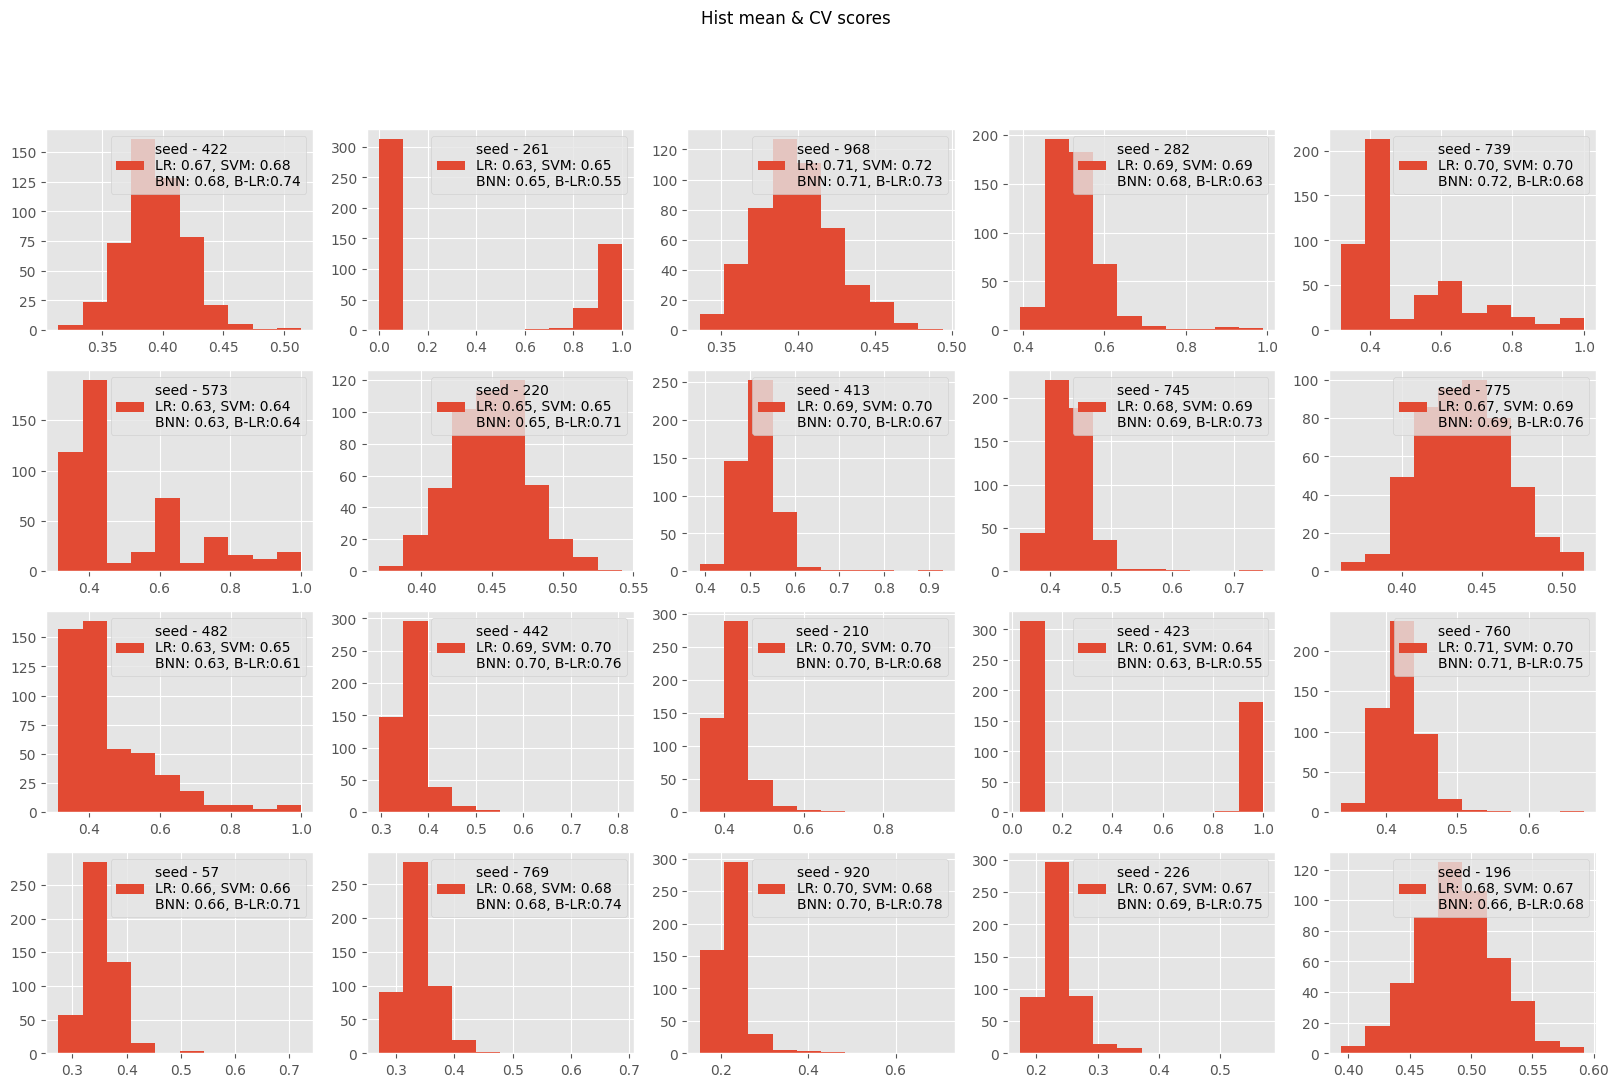

In [142]:
import glob
bnn_disc_means = []

for seed in exp_seeds:
    disc_mean = np.load(f"{exp_dir}/bnn_disc_mean_s_{seed}.npy")
    bnn_disc_means.append(disc_mean)


nrows = 4
ncols = 5
fig, axs = plt.subplots(4, 5, figsize=(20, 12))
fig.suptitle("Hist mean & CV scores")
k = 0
for i in range(nrows):
    for j in range(ncols):
        seed = exp_seeds[k]
        scores = exp_res_summary_df[exp_res_summary_df["seed"] == seed]["cv_score"].to_list()
        axs[i, j].hist(bnn_disc_means[k], label=f"seed - {seed}\nLR: {scores[0]:.2f}, SVM: {scores[1]:.2f}\nBNN: {scores[2]:.2f}, B-LR:{scores[3]:.2f}")
        k += 1
        # axs[i, j].set_title(f"Seed - {seed}")
        axs[i, j].legend()


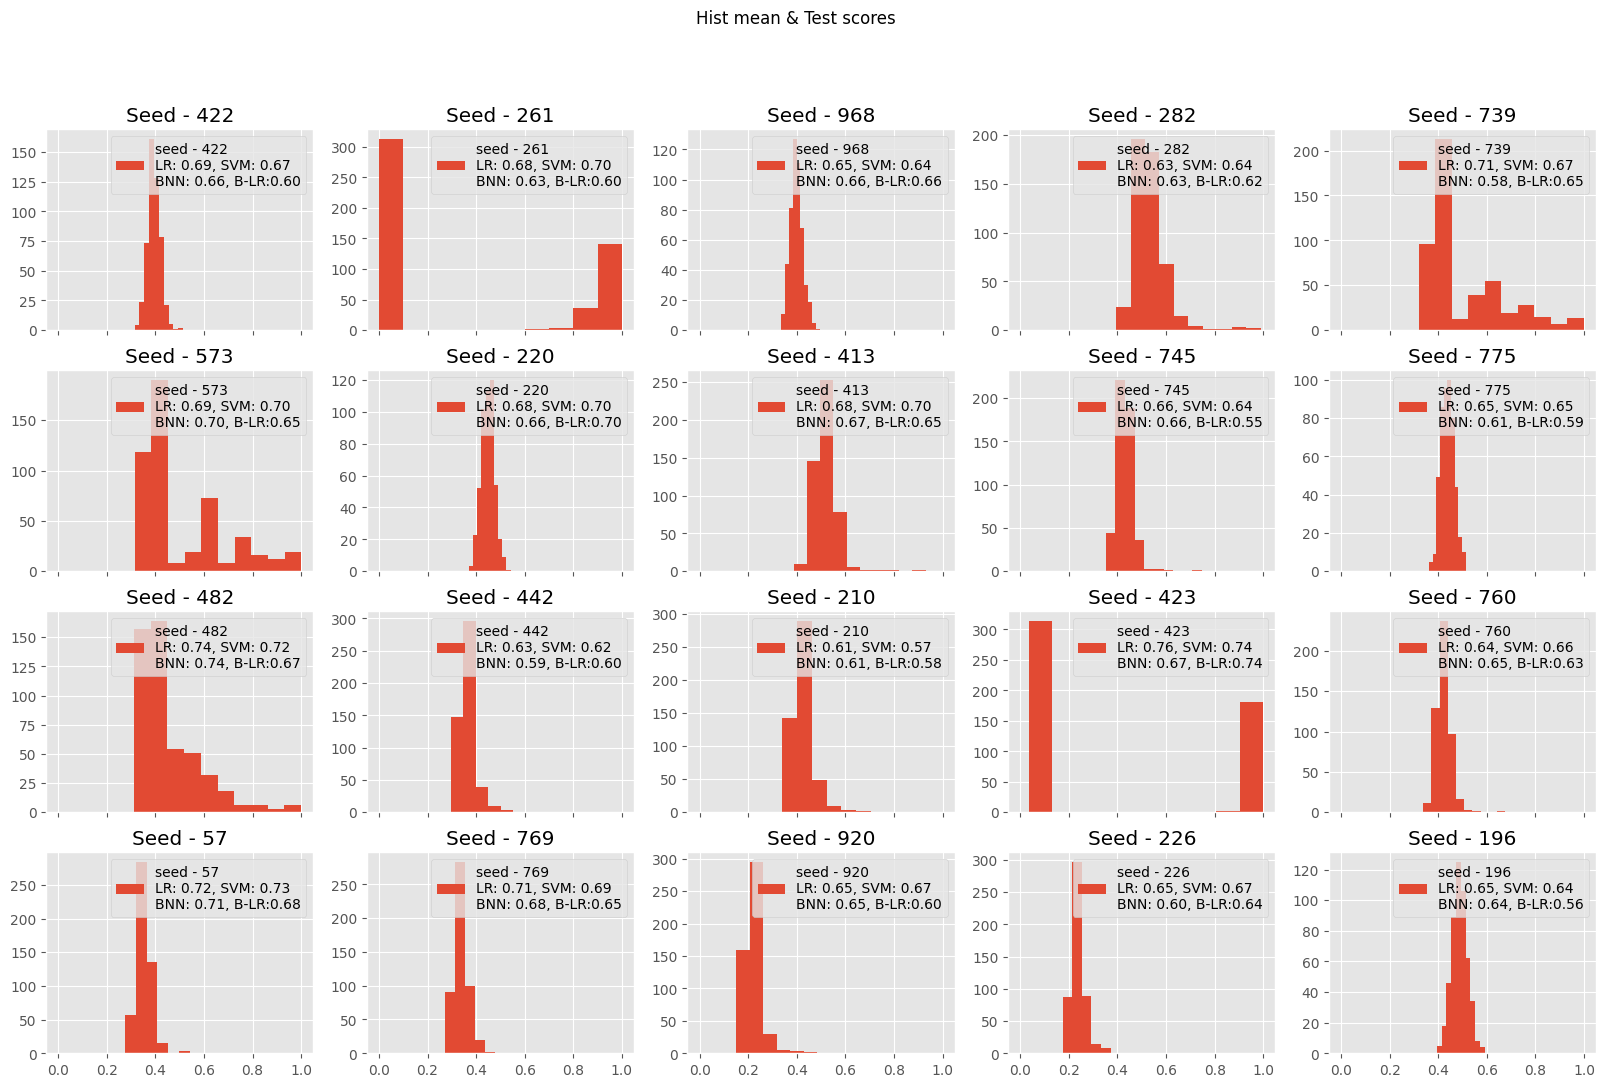

In [48]:
nrows = 4
ncols = 5
fig, axs = plt.subplots(4, 5, figsize=(20, 12), sharex=True)
fig.suptitle("Hist mean & Test scores")
k = 0
for i in range(nrows):
    for j in range(ncols):
        seed = exp_seeds[k]
        scores = exp_res_summary_df[exp_res_summary_df["seed"] == seed]["test_score"].to_list()
        axs[i, j].hist(bnn_disc_means[k], label=f"seed - {seed}\nLR: {scores[0]:.2f}, SVM: {scores[1]:.2f}\nBNN: {scores[2]:.2f}, B-LR:{scores[3]:.2f}")
        k += 1
        axs[i, j].set_title(f"Seed - {seed}")
        axs[i, j].legend()

In [109]:
bnn_lr_quantile = {"seed": [], "cv_score": [], "test_score": [], "feat_len": [], "75%": []}

for seed in exp_seeds:
    cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)
    gamma_means_s = np.load(f"{exp_dir}/bnn_disc_mean_s_{seed}.npy")
    gamma_means_quantile = np.quantile(gamma_means_s, [0., 0.25, 0.5, 0.75, 1.])
    gamma_mean_75 = gamma_means_quantile[3]
    gamma_idx = np.argwhere(gamma_means_s > gamma_mean_75).ravel()
    print(f"seed - {seed}, gamma >75% - {len(gamma_idx)}")
    X_train, X_test, y_train, y_test = train_test_split(X_cosmic, y_df, test_size=0.3, random_state=seed, shuffle=True, stratify=y_df)
    X_train_sel, X_test_sel = X_train.iloc[:, gamma_idx], X_test.iloc[:, gamma_idx]
    log_param_grid = {"C":np.logspace(-2, 1, 10)}
    log_grid_cv = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=log_param_grid, verbose=1, scoring="roc_auc", cv=cv).fit(X_train_sel, y_train.to_numpy())
    print(log_grid_cv.best_params_)
    clf = LogisticRegression(max_iter=10000, C=log_grid_cv.best_params_["C"])
    log_cv_score= np.mean(cross_val_score(clf, X_train_sel, y_train, scoring="roc_auc", cv=cv))
    clf.fit(X_train_sel, y_train)
    log_test_score= roc_auc_score(y_test.to_numpy(), clf.predict_proba(X_test_sel)[:,1])
    print(f"cv score: {log_cv_score}, test_score: {log_test_score}")

    bnn_lr_quantile["seed"].append(seed)
    bnn_lr_quantile["cv_score"].append(log_cv_score)
    bnn_lr_quantile["test_score"].append(log_test_score)
    bnn_lr_quantile["feat_len"].append(len(gamma_idx))
    bnn_lr_quantile["75%"].append(gamma_mean_75)

seed - 422, gamma >75% - 113
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 0.01}
cv score: 0.7447105672105672, test_score: 0.6322838994752831
seed - 261, gamma >75% - 122
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 0.01}
cv score: 0.5571250971250972, test_score: 0.6500966583816625
seed - 968, gamma >75% - 123
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 0.021544346900318832}
cv score: 0.7382420357420358, test_score: 0.6413974040320354
seed - 282, gamma >75% - 118
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 0.01}
cv score: 0.6207051282051281, test_score: 0.5647611157138912
seed - 739, gamma >75% - 121
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 0.046415888336127774}
cv score: 0.6888267288267287, test_score: 0.5934824634078983
seed - 573, gamma >75% - 123
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 0.021544346900318832}
cv score: 0.6364005439005439, test_

In [110]:
bnn_lr_quantile_df = pd.DataFrame(bnn_lr_quantile)
bnn_lr_quantile_df

,seed,cv_score,test_score,feat_len,75%
0,422,0.744711,0.632284,113,0.410
1,261,0.557125,0.650097,122,0.924
2,968,0.738242,0.641397,123,0.414
3,282,0.620705,0.564761,118,0.562
4,739,0.688827,0.593482,121,0.600
5,573,0.636401,0.681994,123,0.622
6,220,0.710515,0.658105,116,0.466
7,413,0.708273,0.657829,119,0.540
8,745,0.771173,0.597349,121,0.448
9,775,0.753588,0.607015,115,0.458


In [111]:
bnn_lr_quantile_df[["cv_score", "test_score"]].mean()

cv_score      0.700757
test_score    0.634431
dtype: float64

In [32]:
bnn_lr_thr = {"seed": [], "cv_score": [], "test_score": [], "feat_len": [], "thr": []}

thr = np.linspace(0.1, 0.9, 9)

for seed in exp_seeds:
    cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)
    gamma_means_s = np.load(f"{exp_dir}/bnn_disc_mean_s_{seed}.npy")
    X_train, X_test, y_train, y_test = train_test_split(X_cosmic, y_df, test_size=0.3, random_state=seed, shuffle=True, stratify=y_df)
    cv_score_max = 0.0
    t_max = 0.0
    param_t_max = None
    for t in thr:
        gamma_idx = np.argwhere(gamma_means_s > t).ravel()
        if gamma_idx.size == 0: break
        X_train_sel, X_test_sel = X_train.iloc[:, gamma_idx], X_test.iloc[:, gamma_idx]
        log_param_grid = {"C":np.logspace(-2, 1, 10)}
        log_grid_cv = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=log_param_grid, verbose=1, scoring="roc_auc", cv=cv).fit(X_train_sel, y_train.to_numpy())
        clf = LogisticRegression(max_iter=10000, C=log_grid_cv.best_params_["C"])
        log_cv_score = log_grid_cv.best_score_
        if log_cv_score > cv_score_max:
            t_max = t
            cv_score_max = log_cv_score
            param_t_max = log_grid_cv.best_params_

    gamma_idx = np.argwhere(gamma_means_s > t_max).ravel()
    X_train_sel, X_test_sel = X_train.iloc[:, gamma_idx], X_test.iloc[:, gamma_idx]
    clf = LogisticRegression(max_iter=10000, **param_t_max)
    log_cv_score= np.mean(cross_val_score(clf, X_train_sel, y_train, scoring="roc_auc", cv=cv))
    clf.fit(X_train_sel, y_train)
    log_test_score= roc_auc_score(y_test.to_numpy(), clf.predict_proba(X_test_sel)[:,1])
    print(f"thr: {t_max}, len: {len(gamma_idx)}  ,cv score: {log_cv_score}, test_score: {log_test_score}")

    bnn_lr_thr["seed"].append(seed)
    bnn_lr_thr["cv_score"].append(log_cv_score)
    bnn_lr_thr["test_score"].append(log_test_score)
    bnn_lr_thr["feat_len"].append(len(gamma_idx))
    bnn_lr_thr["thr"].append(t_max)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
thr: 0.4, len: 186  ,cv score: 0.742952602952603, test_score: 0.6444352388842861
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
thr: 0.7000000000000001, len: 181  ,cv score: 0.6133702408702408,

In [33]:
bnn_lr_thr_df = pd.DataFrame(bnn_lr_thr)
bnn_lr_thr_df

,seed,cv_score,test_score,feat_len,thr
0,422,0.742953,0.644435,186,0.4
1,261,0.613370,0.586164,181,0.7
2,968,0.744920,0.630627,221,0.4
3,282,0.694528,0.606324,329,0.5
4,739,0.749971,0.692626,330,0.4
5,573,0.668972,0.706159,284,0.4
6,220,0.656340,0.682822,477,0.4
7,413,0.718310,0.665838,324,0.5
8,745,0.705412,0.629108,421,0.4
9,775,0.700045,0.545982,9,0.5


In [34]:
bnn_lr_thr_df[["cv_score", "test_score", "feat_len"]].mean()

cv_score        0.703727
test_score      0.642699
feat_len      251.950000
dtype: float64

### MOSES

In [10]:
exp_dir = f"{data_dir}/exp_data_4/cancer/cosmic"
exp_seeds = []
with open(f"{exp_dir}/seeds_main.txt", "r") as fp:
    for line in fp.readlines():
        exp_seeds.append(int(line.strip()))

In [11]:
moses_res_dfs = []
import glob
for file in glob.glob(f"{exp_dir}/moses/res_summary_cosmic_genes_moses_s_*.csv"):
    # print(file)
    moses_res_df = pd.read_csv(file)
    moses_res_dfs.append(moses_res_df)

len(moses_res_dfs)

20

In [12]:
exp_moses_res_df = pd.concat(moses_res_dfs, axis=0)
exp_moses_res_df

,seed,classifier,num_feats,cv_score,test_score
0,775,BNN + MOSES,70,0.677467,0.638944
1,775,BNN + MOSES + LR,70,0.773116,0.648207
0,482,BNN + MOSES,70,0.602535,0.674813
1,482,BNN + MOSES + LR,70,0.617033,0.690185
0,261,BNN + MOSES,70,0.577613,0.502562
1,261,BNN + MOSES + LR,70,0.583853,0.657272
0,226,BNN + MOSES,70,0.698382,0.623768
1,226,BNN + MOSES + LR,70,0.762165,0.671857
0,920,BNN + MOSES,70,0.689792,0.616673
1,920,BNN + MOSES + LR,70,0.767256,0.615294


In [114]:
moses_clf_mean_scs = exp_moses_res_df.groupby("classifier")[["cv_score", "test_score"]].mean()
moses_clf_mean_scs

,cv_score,test_score
classifier,,
BNN + MOSES,0.632846,0.581041
BNN + MOSES + LR,0.695828,0.630252


In [116]:
avg_num_feats = len(cosmic_intr)
res_summary_dict = {"classifier": ["LR", "SVM", "BNN", "BNN + LR", "BNN + LR + MOSES"],
                    "num_feats": [avg_num_feats, avg_num_feats, avg_num_feats, 70, 170],
                    "mean_cv_score": [clf_mean_scs.loc["LR"].cv_score, clf_mean_scs.loc["SVM"].cv_score,
                                      clf_mean_scs.loc["BNN"].cv_score,
                                      clf_mean_scs.loc["BNN + LR"].cv_score,
                                      moses_clf_mean_scs.loc["BNN + MOSES + LR"].cv_score], "mean_test_score":
                        [clf_mean_scs.loc["LR"].test_score, clf_mean_scs.loc["SVM"].test_score,
                         clf_mean_scs.loc["BNN"].test_score,
                         clf_mean_scs.loc["BNN + LR"].test_score,
                         moses_clf_mean_scs.loc["BNN + MOSES + LR"].test_score]}

res_summary_df = pd.DataFrame(res_summary_dict)
res_summary_df

,classifier,num_feats,mean_cv_score,mean_test_score
0,LR,497,0.673300,0.675007
1,SVM,497,0.678274,0.671866
2,BNN,497,0.677512,0.649503
3,BNN + LR,70,0.691744,0.631007
4,BNN + LR + MOSES,170,0.695828,0.630252


### Check the added columns from MOSES

In [13]:
train_evals = []
test_evals = []
exp_dir = f"{data_dir}/exp_data_4/cancer/cosmic"
for seed in exp_seeds:
    train_eval = np.load(f"{exp_dir}/moses/moses_train_eval_out_s_{seed}.npy")
    test_eval = np.load(f"{exp_dir}/moses/moses_test_eval_out_s_{seed}.npy")

    train_evals.append(train_eval)
    test_evals.append(test_eval)

In [95]:
import pickle
from tqdm import tqdm

moses_lr_eval = {"nfeats": [],  "cv_score": [], "test_score": []}

for t in tqdm(range(len(exp_seeds))):
    seed = exp_seeds[t]
    train_eval = train_evals[t]
    test_eval = test_evals[t]
    sel_feat_idx = np.load(f"{exp_dir}/bnn_sel_idx_s_{seed}_n_70.npy")
    params = pickle.load(open(f"{exp_dir}/bnn_lr_best_params_s_{seed}.pickle", "rb"))
    X_train, X_test, y_train, y_test = train_test_split(X_cosmic, y_df, random_state=seed, shuffle=True, stratify=y_df) ## TODO Check this
    X_train_sel, X_test_sel = X_train.iloc[:, sel_feat_idx].to_numpy(), X_test.iloc[:, sel_feat_idx].to_numpy()
    y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

    lr_clf = LogisticRegression(max_iter=10000, **params)
    cv_score = np.mean(cross_val_score(lr_clf, X_train_sel, y_train, cv=cv))
    lr_clf.fit(X_train_sel, y_train)
    test_score = roc_auc_score(y_test, lr_clf.predict_proba(X_test_sel)[:,1])
    Cs = {"C": np.logspace(-2, 1, 10)}

    mm_cv_scs = np.zeros(train_eval.shape[1])
    mm_test_scs = np.zeros(train_eval.shape[1])

    for i in range(train_eval.shape[1]):
        X_train_sel_moses, X_test_sel_moses = np.concatenate([X_train_sel, train_eval[:,:i]], axis=1), \
                                              np.concatenate([X_test_sel, test_eval[:,:i]], axis=1)

        lr_clf = LogisticRegression(max_iter=10000)
        grid_search_cv = GridSearchCV(lr_clf, Cs, scoring="roc_auc").fit(X_train_sel_moses, y_train)
        cv_score = grid_search_cv.best_score_
        lr_clf = LogisticRegression(max_iter=10000, **grid_search_cv.best_params_)
        lr_clf.fit(X_train_sel_moses, y_train)
        test_score = roc_auc_score(y_test, lr_clf.predict_proba(X_test_sel_moses)[:,1])

        mm_cv_scs[i] = cv_score
        mm_test_scs[i] = test_score

    idx_max = np.argmax(mm_cv_scs)
    cv_score = mm_cv_scs[idx_max]
    test_score = mm_test_scs[idx_max]

    moses_lr_eval["nfeats"].append(idx_max)
    moses_lr_eval["cv_score"].append(cv_score)
    moses_lr_eval["test_score"].append(test_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [54:15<00:00, 162.76s/it]


In [143]:
moses_lr_eval_df = pd.DataFrame(moses_lr_eval)
# moses_lr_eval_df.to_csv(f"{exp_dir}/moses/moses_lr_eval.csv", index=False)
moses_lr_eval_df

,nfeats,cv_score,test_score
0,13,0.750903,0.620615
1,99,0.581013,0.652937
2,11,0.727245,0.697280
3,23,0.666135,0.614505
4,33,0.656750,0.687426
5,56,0.660224,0.636776
6,39,0.756881,0.686244
7,20,0.704130,0.599724
8,16,0.739489,0.492905
9,13,0.788771,0.640323


In [112]:
moses_lr_eval_df[["cv_score", "test_score"]].mean()

cv_score      0.704824
test_score    0.632785
dtype: float64

### Rank the models by logistic regression coefficient

In [137]:
moses_models_lr_eval = {"seed": [],  "cv_score": [], "test_score": []}

for t in tqdm(range(len(exp_seeds))):
    seed = exp_seeds[t]
    train_eval = train_evals[t]
    test_eval = test_evals[t]
    _, _, y_train, y_test = train_test_split(X_cosmic, y_df, random_state=seed, shuffle=True, stratify=y_df) ## TODO Check this
    y_train, y_test = y_train.to_numpy(), y_test.to_numpy()
    Cs = {"C": np.logspace(-2, 1, 10)}

    lr_clf = LogisticRegression(max_iter=10000)
    grid_search_cv = GridSearchCV(lr_clf, Cs, scoring="roc_auc").fit(train_eval, y_train)
    cv_score = grid_search_cv.best_score_
    lr_clf = LogisticRegression(max_iter=10000, **grid_search_cv.best_params_)
    lr_clf.fit(train_eval, y_train)
    test_score = roc_auc_score(y_test, lr_clf.predict_proba(test_eval)[:,1])


    moses_models_lr_eval["seed"].append(seed)
    moses_models_lr_eval["cv_score"].append(cv_score)
    moses_models_lr_eval["test_score"].append(test_score)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.97s/it]


In [138]:
moses_models_lr_eval_df = pd.DataFrame(moses_models_lr_eval)
moses_models_lr_eval_df[["cv_score", "test_score"]].mean()

cv_score      0.640002
test_score    0.584076
dtype: float64

In [139]:
moses_models_lr_ranked = {"seed": [],  "cv_score": [], "test_score": []}

for t in tqdm(range(len(exp_seeds))):
    seed = exp_seeds[t]
    train_eval = train_evals[t]
    test_eval = test_evals[t]

    sel_feat_idx = np.load(f"{exp_dir}/bnn_sel_idx_s_{seed}_n_70.npy")
    params = pickle.load(open(f"{exp_dir}/bnn_lr_best_params_s_{seed}.pickle", "rb"))
    X_train, X_test, y_train, y_test = train_test_split(X_cosmic, y_df, random_state=seed, shuffle=True, stratify=y_df) ## TODO Check this
    X_train_sel, X_test_sel = X_train.iloc[:, sel_feat_idx].to_numpy(), X_test.iloc[:, sel_feat_idx].to_numpy()
    y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

    Cs = {"C": np.logspace(-2, 1, 10)}

    lr_clf = LogisticRegression(max_iter=10000)
    grid_search_cv = GridSearchCV(lr_clf, Cs, scoring="roc_auc").fit(train_eval, y_train)
    cv_score = grid_search_cv.best_score_
    lr_clf = LogisticRegression(max_iter=10000, **grid_search_cv.best_params_)
    lr_clf.fit(train_eval, y_train)
    weights = lr_clf.coef_[0]
    weight_idx = np.argsort(weights)[::-1][:10]

    X_train_sel_moses, X_test_sel_moses = np.concatenate([X_train_sel, train_eval[:,weight_idx]], axis=1), \
                                          np.concatenate([X_test_sel, test_eval[:,weight_idx]], axis=1)

    lr_clf = LogisticRegression(max_iter=10000)
    grid_search_cv = GridSearchCV(lr_clf, Cs, scoring="roc_auc").fit(X_train_sel_moses, y_train)
    cv_score = grid_search_cv.best_score_
    lr_clf = LogisticRegression(max_iter=10000, **grid_search_cv.best_params_)
    lr_clf.fit(X_train_sel_moses, y_train)
    test_score = roc_auc_score(y_test, lr_clf.predict_proba(X_test_sel_moses)[:,1])


    moses_models_lr_ranked["seed"].append(seed)
    moses_models_lr_ranked["cv_score"].append(cv_score)
    moses_models_lr_ranked["test_score"].append(test_score)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [02:25<00:00,  7.26s/it]


In [140]:
moses_models_lr_ranked_df = pd.DataFrame(moses_models_lr_ranked)
moses_models_lr_ranked_df[["cv_score", "test_score"]].mean()

cv_score      0.703536
test_score    0.632036
dtype: float64

### Check Non-linearity of selected features

In [165]:
svm_param_kernels = {"seed": [], "cv_score": [], "test_score": [], "kernel": []}

for seed in tqdm(exp_seeds):
    svc_params = pickle.load(open(f"{exp_dir}/svm_best_params_s_{seed}.pickle", "rb"))

    svm_res = exp_res_summary_df[(exp_res_summary_df["seed"] == seed) &
                                 (exp_res_summary_df["classifier"] == "SVM")]
    svc_cv_score = svm_res["cv_score"].iloc[0]
    svc_test_score = svm_res["test_score"].iloc[0]

    svm_param_kernels["seed"].append(seed)
    svm_param_kernels["cv_score"].append(svc_cv_score)
    svm_param_kernels["test_score"].append(svc_test_score)
    svm_param_kernels["kernel"].append(svc_params["kernel"])


svm_param_kernels_df = pd.DataFrame(svm_param_kernels)
svm_param_kernels_df

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 2138.10it/s]


,seed,cv_score,test_score,kernel
0,422,0.679388,0.667909,rbf
1,261,0.652259,0.695526,rbf
2,968,0.720783,0.643745,rbf
3,282,0.691037,0.643192,rbf
4,739,0.702133,0.673985,rbf
5,573,0.639540,0.701464,rbf
6,220,0.649957,0.703673,rbf
7,413,0.702341,0.701188,rbf
8,745,0.691233,0.639878,rbf
9,775,0.685546,0.652030,rbf


In [24]:
from sklearn.svm import SVC
from tqdm import tqdm
bnn_sel_fts_svm = {"seed": [], "cv_score": [], "test_score": [], "kernel": []}

for seed in tqdm(exp_seeds):
    cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)
    sel_feat_idx = np.load(f"{exp_dir}/bnn_sel_idx_s_{seed}_n_70.npy")
    # print(idx_sig)
    X_train, X_test, y_train, y_test = train_test_split(X_cosmic, y_df, test_size=0.3, random_state=seed, shuffle=True, stratify=y_df)
    X_train_sel, X_test_sel = X_train.iloc[:, sel_feat_idx].to_numpy(), X_test.iloc[:, sel_feat_idx].to_numpy()

    y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

    svc_param_grid = {"C": np.logspace(-2, 1, 10), "kernel": ["rbf", "linear", "poly"], "degree": [2, 3]}
    svc_grid_cv = GridSearchCV(estimator=SVC(probability=True), param_grid=svc_param_grid, verbose=0,
                               scoring="roc_auc", cv=cv).fit(X_train_sel, y_train)

    svc_cv_score = svc_grid_cv.best_score_
    clf = SVC(probability=True,  **svc_grid_cv.best_params_)
    clf.fit(X_train_sel, y_train)
    svc_test_score = roc_auc_score(y_test, clf.predict_proba(X_test_sel)[:, 1])

    bnn_sel_fts_svm["seed"].append(seed)
    bnn_sel_fts_svm["cv_score"].append(svc_cv_score)
    bnn_sel_fts_svm["test_score"].append(svc_test_score)
    bnn_sel_fts_svm["kernel"].append(svc_grid_cv.best_params_["kernel"])


bnn_sel_fts_svm_df = pd.DataFrame(bnn_sel_fts_svm)
bnn_sel_fts_svm_df

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [04:16<00:00, 12.82s/it]


,seed,cv_score,test_score,kernel
0,422,0.744633,0.608672,poly
1,261,0.584643,0.579398,poly
2,968,0.731090,0.681856,rbf
3,282,0.653846,0.638912,rbf
4,739,0.686620,0.628556,rbf
5,573,0.645245,0.616819,poly
6,220,0.705462,0.668876,linear
7,413,0.694066,0.644573,rbf
8,745,0.739303,0.558824,rbf
9,775,0.769274,0.586854,rbf


In [147]:
bnn_sel_fts_svm_df[["cv_score", "test_score"]].mean()

cv_score      0.702873
test_score    0.627182
dtype: float64

In [197]:
from sklearn.neural_network import MLPClassifier

feat_lens = np.arange(10, 110, 10)

bnn_feat_len_dict = {"seed": [], "num_feats": [], "cv_score": [], "test_score": []}

for seed in tqdm(exp_seeds):

    cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)
    gamma_means = np.load(f"{exp_dir}/bnn_disc_mean_s_{seed}.npy")
    gamma_means_idx_s = np.argsort(gamma_means)[::-1]
    X_train, X_test, y_train, y_test = train_test_split(X_cosmic, y_df, test_size=0.3, random_state=seed, shuffle=True, stratify=y_df)
    X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
    y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

    cv_score_max = 0.0
    flen_max = 0.0
    param_flen_max = None

    layer_dim = 100

    for feat_len in feat_lens:
        gamma_idx = gamma_means_idx_s[:feat_len]
        cv_scores = []
        # layer_dim = int(2/3*(feat_len + 1))

        mlp = MLPClassifier(hidden_layer_sizes=(layer_dim,), activation="tanh", early_stopping=True, random_state=seed, batch_size=20, max_iter=300)
        for train_idx, test_idx in cv.split(X_train, y_train):
            x_train_cv, y_train_cv = X_train[train_idx], y_train[train_idx]
            x_test_cv, y_test_cv = X_train[test_idx], y_train[test_idx]
            x_train_cv_sel, x_test_cv_sel = x_train_cv[:,gamma_idx], x_test_cv[:,gamma_idx]
            mlp.fit(x_train_cv_sel, y_train_cv)
            cv_scores.append(roc_auc_score(y_test_cv, mlp.predict_proba(x_test_cv_sel)[:,1]))

        cv_score = np.mean(np.array(cv_scores))
        # print(f"feat_len: {feat_len}, cv_score: {cv_score}")
        if cv_score > cv_score_max:
            cv_score_max = cv_score
            flen_max = feat_len

    # layer_dim = int(2/3*(flen_max + 1))
    mlp = MLPClassifier(hidden_layer_sizes=(layer_dim,), activation="tanh", early_stopping=True, random_state=seed, batch_size=20, max_iter=300)
    gamma_idx = gamma_means_idx_s[:flen_max]
    X_train_sel, X_test_sel = X_train[:,gamma_idx], X_test[:,gamma_idx]
    mlp.fit(X_train_sel, y_train)
    test_score = roc_auc_score(y_test, mlp.predict_proba(X_test_sel)[:,1])
    # print(f"seed: {seed}, Optim feat len: {flen_max}, cv_score: {cv_score_max}, test_score: {test_score}")

    bnn_feat_len_dict["seed"].append(seed)
    bnn_feat_len_dict["num_feats"].append(flen_max)
    bnn_feat_len_dict["cv_score"].append(cv_score_max)
    bnn_feat_len_dict["test_score"].append(test_score)



bnn_feat_len_df = pd.DataFrame(bnn_feat_len_dict)
bnn_feat_len_df


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [02:07<00:00,  6.40s/it]


,seed,num_feats,cv_score,test_score
0,422,40,0.725270,0.627727
1,261,100,0.583493,0.567385
2,968,70,0.713561,0.655344
3,282,70,0.642836,0.649820
4,739,100,0.681232,0.579950
5,573,100,0.618996,0.611709
6,220,90,0.685148,0.648440
7,413,90,0.662178,0.658105
8,745,100,0.694918,0.656587
9,775,80,0.757523,0.593206


In [198]:
bnn_feat_len_df[["cv_score", "test_score"]].mean()

cv_score      0.682657
test_score    0.616204
dtype: float64

In [200]:
bnn_sel_fts_svm_df[["cv_score", "test_score"]].mean()
from sklearn.neural_network import MLPClassifier

feat_lens = np.arange(10, 110, 10)

bnn_feat_len_svm_dict = {"seed": [], "num_feats": [], "cv_score": [], "test_score": [], "kernel": []}

for seed in tqdm(exp_seeds):

    cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)
    gamma_means = np.load(f"{exp_dir}/bnn_disc_mean_s_{seed}.npy")
    gamma_means_idx_s = np.argsort(gamma_means)[::-1]
    X_train, X_test, y_train, y_test = train_test_split(X_cosmic, y_df, test_size=0.3, random_state=seed, shuffle=True,
                                                        stratify=y_df)
    X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
    y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

    cv_score_max = 0.0
    flen_max = 0.0
    param_flen_max = None

    svc_param_grid = {"C": np.logspace(-2, 1, 10), "kernel": ["rbf", "linear", "poly"], "degree": [2, 3]}
    for feat_len in feat_lens:
        gamma_idx = gamma_means_idx_s[:feat_len]
        X_train_sel, X_test_sel = X_train[:,gamma_idx], X_test[:,gamma_idx]
        svc_grid_cv = GridSearchCV(estimator=SVC(probability=True), param_grid=svc_param_grid, verbose=0,
                                   scoring="roc_auc", cv=cv).fit(X_train_sel, y_train)

        cv_score = svc_grid_cv.best_score_
        if cv_score > cv_score_max:
            cv_score_max = cv_score
            flen_max = feat_len
            param_flen_max = svc_grid_cv.best_params_

    gamma_idx = gamma_means_idx_s[:flen_max]
    X_train_sel, X_test_sel = X_train[:, gamma_idx], X_test[:, gamma_idx]
    svc_clf = SVC(probability=True, **param_flen_max)
    svc_clf.fit(X_train_sel, y_train)
    test_score = roc_auc_score(y_test, svc_clf.predict_proba(X_test_sel)[:, 1])
    # print(f"seed: {seed}, Optim feat len: {flen_max}, cv_score: {cv_score_max}, test_score: {test_score}")

    bnn_feat_len_svm_dict["seed"].append(seed)
    bnn_feat_len_svm_dict["num_feats"].append(flen_max)
    bnn_feat_len_svm_dict["cv_score"].append(cv_score_max)
    bnn_feat_len_svm_dict["test_score"].append(test_score)
    bnn_feat_len_svm_dict["kernel"].append(param_flen_max["kernel"])

bnn_feat_len_svm_df = pd.DataFrame(bnn_feat_len_svm_dict)
bnn_feat_len_svm_df

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [32:01<00:00, 96.06s/it]


,seed,num_feats,cv_score,test_score,kernel
0,422,90,0.760674,0.604943,poly
1,261,100,0.594893,0.610191,poly
2,968,90,0.739734,0.634493,rbf
3,282,50,0.676045,0.668738,rbf
4,739,100,0.713963,0.568351,rbf
5,573,80,0.665754,0.640983,poly
6,220,80,0.708895,0.657967,linear
7,413,100,0.730118,0.672466,rbf
8,745,100,0.768720,0.595001,poly
9,775,70,0.777201,0.595554,rbf


In [14]:
# bnn_feat_len_svm_df.to_csv(f"{exp_dir}/moses/bnn_cosmic_feat_len_svm.csv")
bnn_feat_len_svm_df = pd.read_csv(f"{exp_dir}/moses/bnn_cosmic_feat_len_svm.csv")

In [21]:
bnn_feat_len_svm_df[["num_feats", "cv_score", "test_score"]].mean()

num_feats     77.000000
cv_score       0.717182
test_score     0.631942
dtype: float64

In [15]:
bnn_feat_len_svm_df[(bnn_feat_len_svm_df["kernel"] != "linear")][["cv_score", "test_score"]].mean()

cv_score      0.716179
test_score    0.630830
dtype: float64

In [16]:
bnn_feat_len_svm_df["kernel"].value_counts()

rbf       9
poly      7
linear    4
Name: kernel, dtype: int64

In [26]:
bnn_feat_len_svm_df[(bnn_feat_len_svm_df["kernel"] == "linear")][["cv_score", "test_score"]].mean()

cv_score      0.721196
test_score    0.636392
dtype: float64

In [ ]:
%autoreload
from run_moses_cosmic_exp import run_moses, run_logistc_regression

feat_lens = np.arange(10, 110, 10)

bnn_feat_len_moses_dict = {"seed": [], "classifier": [] ,"num_feats": [], "cv_score": [], "test_score": [],
                           "kernel": []}

moses_grid_params = {"complexity_ratio": np.logspace(0, 3, 5), "complexity_temp": np.logspace(1, 3, 5),
                     "diversity_pressure": [0.0, 0.3, 0.6, 0.9], "hc_fraction_nn": [0.01, 0.1],
                     }

for seed in exp_seeds:

    cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)
    gamma_means = np.load(f"{exp_dir}/bnn_disc_mean_s_{seed}.npy")
    gamma_means_idx_s = np.argsort(gamma_means)[::-1]
    X_train, X_test, y_train, y_test = train_test_split(X_cosmic, y_df, test_size=0.3, random_state=seed, shuffle=True,
                                                        stratify=y_df)
    # X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
    # y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

    feat_len = bnn_feat_len_svm_df[bnn_sel_fts_svm_df["seed"] == seed]["num_feats"].iloc[0]
    kernel = bnn_feat_len_svm_df[bnn_sel_fts_svm_df["seed"] == seed]["kernel"].iloc[0]
    gamma_idx = gamma_means_idx_s[:feat_len]
    X_train_sel, X_test_sel = X_train.iloc[:,gamma_idx], X_test.iloc[:,gamma_idx]

    _, moses_cv_score, moses_test_score, \
        train_eval_out, test_eval_out = run_moses(seed, X_train_sel, X_test_sel, y_train, y_test, "posOutcome", cv)

    X_train_sel_moses = np.concatenate([X_train_sel.to_numpy(), train_eval_out], axis=1)
    X_test_sel_moses = np.concatenate([X_test_sel.to_numpy(), test_eval_out], axis=1)

    _, log_cv_score, log_test_score = run_logistc_regression(X_train_sel_moses, X_test_sel_moses,
                                                                                 y_train, y_test, cv)

    bnn_feat_len_moses_dict["classifier"].append("MOSES")
    bnn_feat_len_moses_dict["seed"].append(seed)
    bnn_feat_len_moses_dict["num_feats"].append(feat_len)
    bnn_feat_len_moses_dict["cv_score"].append(moses_cv_score)
    bnn_feat_len_moses_dict["test_score"].append(moses_test_score)
    bnn_feat_len_moses_dict["kernel"].append(kernel)

    bnn_feat_len_moses_dict["classifier"].append("MOSES + LR")
    bnn_feat_len_moses_dict["seed"].append(seed)
    bnn_feat_len_moses_dict["num_feats"].append(feat_len + train_eval_out.shape[1])
    bnn_feat_len_moses_dict["cv_score"].append(log_cv_score)
    bnn_feat_len_moses_dict["test_score"].append(log_test_score)
    bnn_feat_len_moses_dict["kernel"].append(kernel)

bnn_feat_len_moses_df = pd.DataFrame(bnn_feat_len_moses_dict)
bnn_feat_len_moses_df

In [213]:
bnn_feat_len_moses_df.groupby("classifier")[["cv_score", "test_score"]].mean()

,cv_score,test_score
classifier,,
MOSES,0.628525,0.575970
MOSES + LR,0.710400,0.630544


In [220]:
bnn_feat_len_moses_df[(bnn_feat_len_moses_df["kernel"] != "linear") & (bnn_feat_len_moses_df["classifier"] == "MOSES + LR")][["cv_score", "test_score"]].mean()

cv_score      0.708501
test_score    0.631317
dtype: float64

In [214]:
bnn_feat_len_moses_df.to_csv(f"{exp_dir}/moses/bnn_cosmic_feat_len_moses.csv")

In [ ]:
%autoreload
from run_moses_cosmic_exp import run_moses, run_logistc_regression

feat_lens = np.arange(10, 110, 10)

bnn_feat_len_lr_dict = {"seed": [], "classifier": [] ,"num_feats": [], "cv_score": [], "test_score": [],
                        "kernel": []}

moses_grid_params = {"complexity_ratio": np.logspace(0, 3, 5), "complexity_temp": np.logspace(1, 3, 5),
                     "diversity_pressure": [0.0, 0.3, 0.6, 0.9], "hc_fraction_nn": [0.01, 0.1],
                     }

for seed in exp_seeds:

    cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)
    gamma_means = np.load(f"{exp_dir}/bnn_disc_mean_s_{seed}.npy")
    gamma_means_idx_s = np.argsort(gamma_means)[::-1]
    X_train, X_test, y_train, y_test = train_test_split(X_cosmic, y_df, test_size=0.3, random_state=seed, shuffle=True,
                                                        stratify=y_df)
    # X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
    # y_train, y_test = y_train.to_numpy(), y_test.to_numpy()
    feat_len = bnn_feat_len_svm_df[bnn_sel_fts_svm_df["seed"] == seed]["num_feats"].iloc[0]
    kernel = bnn_feat_len_svm_df[bnn_sel_fts_svm_df["seed"] == seed]["kernel"].iloc[0]
    gamma_idx = gamma_means_idx_s[:feat_len]
    X_train_sel, X_test_sel = X_train.iloc[:,gamma_idx], X_test.iloc[:,gamma_idx]

    _, log_cv_score, log_test_score = run_logistc_regression(X_train_sel, X_test_sel, y_train, y_test, cv)


    bnn_feat_len_lr_dict["classifier"].append("LR")
    bnn_feat_len_lr_dict["seed"].append(seed)
    bnn_feat_len_lr_dict["num_feats"].append(feat_len)
    bnn_feat_len_lr_dict["cv_score"].append(log_cv_score)
    bnn_feat_len_lr_dict["test_score"].append(log_test_score)
    bnn_feat_len_lr_dict["kernel"].append(kernel)


bnn_feat_len_lr_df = pd.DataFrame(bnn_feat_len_lr_dict)
bnn_feat_len_lr_df

In [218]:
bnn_feat_len_lr_df[bnn_feat_len_lr_df["kernel"] != "linear"][["cv_score", "test_score"]].mean()

cv_score      0.696233
test_score    0.630679
dtype: float64

### Check very small feature size

#### Randomly selected features vs BNN Selected features

In [26]:
%autoreload
from run_moses_cosmic_exp import run_moses, run_logistc_regression
from tqdm import tqdm

rand_v_bnn_sel_fts_dict = {"seed": [], "feat_sel": [], "num_feats": [], "cv_score": [], "test_score": []}

all_feats = np.arange(X_df.shape[1])

feat_lens = [5, 10, 15, 20]

for seed in tqdm(exp_seeds):

    cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)
    gamma_means = np.load(f"{exp_dir}/bnn_disc_mean_s_{seed}.npy")
    gamma_means_idx_s = np.argsort(gamma_means)[::-1]
    X_train_cosmic, X_test_cosmic, y_train, y_test = train_test_split(X_cosmic, y_df, test_size=0.3, random_state=seed, shuffle=True, stratify=y_df)
    X_train_cosmic, X_test_cosmic = X_train_cosmic.to_numpy(), X_test_cosmic.to_numpy()
    y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

    X_train, X_test, _, _ = train_test_split(X_df, y_df, test_size=0.3, random_state=seed, shuffle=True, stratify=y_df)

    X_train, X_test = X_train.to_numpy(), X_test.to_numpy()

    rng_key = jax.random.PRNGKey(seed)

    for ft_len in feat_lens:
        rand_sel_fts = jax.random.choice(rng_key, all_feats, (ft_len,), replace=False)

        X_train_rand_sel, X_test_rand_sel = X_train[:,rand_sel_fts], X_test[:,rand_sel_fts]

        _, rand_cv_score, rand_test_score = run_logistc_regression(X_train_rand_sel, X_test_rand_sel,
                                                                 y_train, y_test, cv, verbose=0)

        sel_fts = gamma_means_idx_s[:ft_len]

        X_train_sel, X_test_sel = X_train_cosmic[:,sel_fts], X_test_cosmic[:,sel_fts]

        _, cv_score, test_score = run_logistc_regression(X_train_sel, X_test_sel,
                                                         y_train, y_test, cv, verbose=0)

        rand_v_bnn_sel_fts_dict["seed"].append(seed)
        rand_v_bnn_sel_fts_dict["feat_sel"].append("random")
        rand_v_bnn_sel_fts_dict["num_feats"].append(ft_len)
        rand_v_bnn_sel_fts_dict["cv_score"].append(rand_cv_score)
        rand_v_bnn_sel_fts_dict["test_score"].append(rand_test_score)

        rand_v_bnn_sel_fts_dict["seed"].append(seed)
        rand_v_bnn_sel_fts_dict["feat_sel"].append("bnn")
        rand_v_bnn_sel_fts_dict["num_feats"].append(ft_len)
        rand_v_bnn_sel_fts_dict["cv_score"].append(cv_score)
        rand_v_bnn_sel_fts_dict["test_score"].append(test_score)


rand_v_bnn_sel_fts_df = pd.DataFrame(rand_v_bnn_sel_fts_dict)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.47s/it]


In [21]:
rand_v_bnn_sel_fts_df

,seed,feat_sel,num_feats,cv_score,test_score
0,422,random,5,0.519374,0.535487
1,422,bnn,5,0.671839,0.570561
2,422,random,10,0.540410,0.533761
3,422,bnn,10,0.670679,0.588926
4,422,random,15,0.533021,0.583264
...,...,...,...,...,...
155,196,bnn,10,0.506659,0.518572
156,196,random,15,0.557913,0.578984
157,196,bnn,15,0.506500,0.537144
158,196,random,20,0.625684,0.612607


In [27]:
rand_v_bnn_sel_fts_df.groupby(["feat_sel", "num_feats"])[["cv_score", "test_score"]].mean()

cv_score  test_score
feat_sel num_feats                      
bnn      5          0.556593    0.549040
         10         0.579746    0.572535
         15         0.609447    0.588322
         20         0.626533    0.590565
random   5          0.538098    0.552075
         10         0.572175    0.569200
         15         0.587249    0.588398
         20         0.602351    0.589457